In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [6]:
pickle_in = open("../data/nitrate.pickle", "rb")
nitrate = pickle.load(pickle_in)
nitrate.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE,NITRATE_VALUE
count,8.633000e+03,8.633000e+03,8.633000e+03,8.633000e+03,8.633000e+03,8.633000e+03,8633.000000
mean,3.344892e-15,-6.749045e-17,1.053509e-16,-9.876651e-18,1.451868e-15,5.201703e-14,5.390403
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.419210
min,-1.881004e+00,-1.869771e+00,-2.896882e-01,-1.981563e+00,-2.720398e+00,-3.858994e+00,1.010000
25%,-6.188348e-01,-8.595868e-01,-2.896882e-01,-5.734262e-01,-6.929795e-01,-6.762150e-01,2.300000
50%,-7.790522e-02,1.109823e-01,-2.896882e-01,-1.157818e-01,-7.366784e-02,1.947435e-02,4.700000
75%,4.630243e-01,8.042460e-01,-2.896882e-01,6.586932e-01,6.228401e-01,7.151637e-01,8.100000
max,3.257827e+00,1.735200e+00,3.666581e+00,2.137236e+00,4.981819e+00,2.906585e+00,20.000000


In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.2.0'

In [2]:
tf.__version__

'2.2.0'

In [7]:
len(nitrate.index)

8633

In [8]:
nitrate.mean()

Year                -6.906145e-15
Yday                 1.486642e-17
Hour                 1.407659e-14
PRESSURE            -7.743397e-16
TEMPERATURE_VALUE    1.398343e-15
SALINITY_VALUE       5.081066e-14
NITRATE_VALUE        5.390403e+00
dtype: float64

In [9]:
## Train test split
train_dataset = nitrate.sample(frac=0.8, random_state=0)
test_dataset  = nitrate.drop(train_dataset.index)

In [10]:
train_labels = train_dataset.pop('NITRATE_VALUE')
test_labels = test_dataset.pop('NITRATE_VALUE')

In [11]:
# train_mean = train_labels.mean()
# train_std = train_labels.std()

In [12]:
# train_labels = (train_labels - train_mean)/train_std
# test_labels = (test_labels - train_mean)/train_std

In [13]:
train_dataset.head()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
12997,0.733489,0.883476,-0.289688,-0.573426,0.802771,0.836909
7496,-0.168060,0.566556,-0.289688,1.714796,-1.147451,-0.632734
12810,0.733489,-0.790260,-0.289688,-0.221392,1.609560,1.028224
11792,0.553179,-1.840060,-0.289688,-0.925460,0.663470,-0.145752
5448,-0.438525,-1.305256,-0.289688,0.130642,-0.874652,-0.667519


### The Model

In [14]:
class descaled_mape(keras.losses.Loss):
    """
    A loss/metric that (de)scales true and predicted values into absolute units before calculating mean absolute percentage error (mape).
    Args:
        mu: mean (usually training data mean)
        sd: standard dev (usually based on training data)
        reduction: Type of tf.keras.losses.Reduction to apply to loss.
        name: name of loss function
    """
    def __init__(self, mu, sd, reduction=keras.losses.Reduction.AUTO, name='descaled_mape'):
        super().__init__(reduction=reduction, name=name)
        self.mu=mu
        self.sd=sd
    
    def call(self, y_true, y_pred):
        y_true = y_true * self.sd + self.mu
        y_pred = y_pred * self.sd + self.mu
        return tf.math.reduce_mean(tf.abs((y_true - y_pred)/y_true))

In [15]:
def build_model():
    model = keras.Sequential([
      layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(8, activation='relu'),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',#descaled_mape(mu = train_mean, sd = train_std),
                 optimizer=optimizer,
                 metrics=[#descaled_mape(mu = train_mean, sd = train_std), 
                     'mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [16]:
model = build_model()

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 168,849
Trainable params: 168,849
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.09533133],
       [-0.02190031],
       [-0.10843889],
       [-0.05403969],
       [ 0.00461065],
       [-0.06469439],
       [-0.07383846],
       [ 0.00468365],
       [-0.07831514],
       [-0.09662028]], dtype=float32)

In [19]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [20]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.155132,1.027889,2.155132,27.742566,2.917212,1.217285,2.917212,35.927847
std,0.568368,0.147757,0.568368,4.110378,0.351987,0.088747,0.351987,3.308626
min,1.432033,0.824411,1.432033,21.813334,2.570315,1.114238,2.570315,30.910240
25%,1.732468,0.912999,1.732468,24.472487,2.732052,1.164858,2.732052,33.765242
50%,2.052609,1.002008,2.052609,27.069641,2.808418,1.184866,2.808418,35.242807
75%,2.492345,1.124190,2.492345,30.600896,2.985004,1.237334,2.985004,37.078050
max,5.041182,1.624504,5.041182,41.982880,4.956973,1.676803,4.956973,49.139202


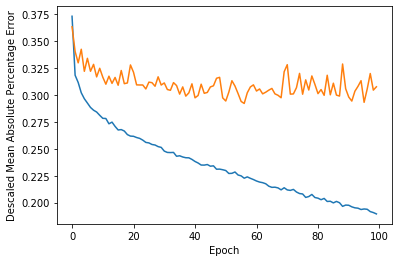

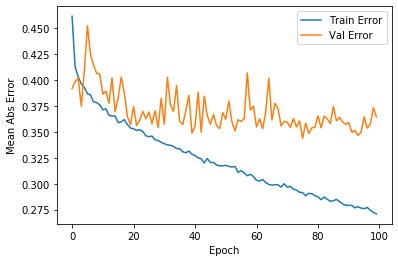

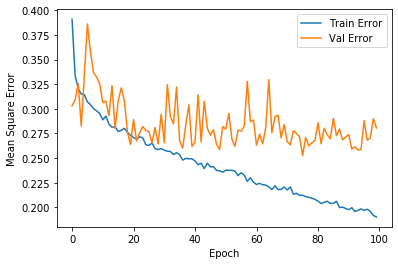

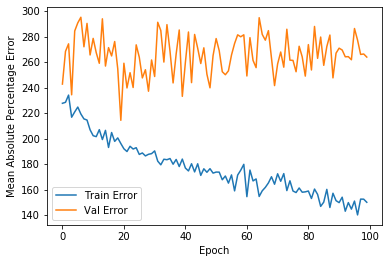

In [51]:
# def plot_history(history):
#   hist = pd.DataFrame(history.history)
#   hist['epoch'] = history.epoch

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Descaled Mean Absolute Percentage Error')
#   plt.plot(hist['epoch'], hist['descaled_mape'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_descaled_mape'],
#            label = 'Val Error')
# #   plt.ylim([0.9,
    
#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Abs Error')
#   plt.plot(hist['epoch'], hist['mae'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mae'],
#            label = 'Val Error')
# #   plt.ylim([0.9,2])
#   plt.legend()

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Square Error')
#   plt.plot(hist['epoch'], hist['mse'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mse'],
#            label = 'Val Error')
# #   plt.ylim([1.8,7])
#   plt.legend()

#   plt.figure()
#   plt.xlabel('Epoch')
#   plt.ylabel('Mean Absolute Percentage Error')
#   plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
#            label='Train Error')
#   plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
#            label = 'Val Error')
# #   plt.ylim([80,160])
#   plt.legend()
#   plt.show()


# plot_history(history)

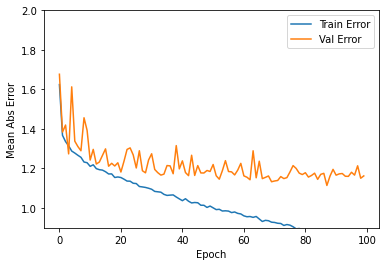

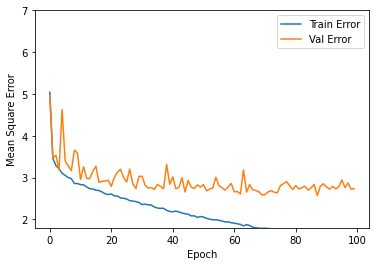

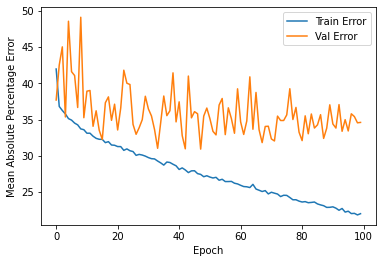

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [84]:
loss, mae, mse, mape = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Percentage Error: {:5.2f}".format(mape))

1727/1727 - 0s - loss: 2.4460 - mae: 1.0997 - mse: 2.4460 - mean_absolute_percentage_error: 29.6365
Testing set Mean Abs Percentage Error: 29.64


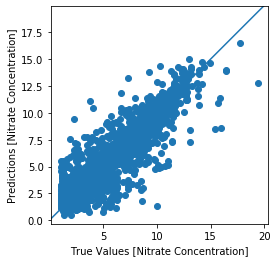

In [85]:
## Make predictions
test_predictions = model.predict(test_dataset).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Nitrate Concentration]')
plt.ylabel('Predictions [Nitrate Concentration]')
plt.axis('equal')
plt.axis('square')
_ = plt.plot([-300, 500], [-300, 500])

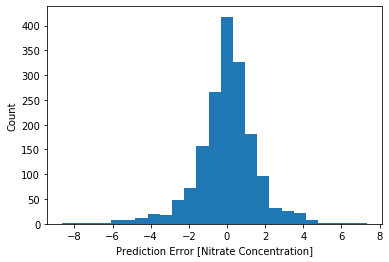

In [86]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Nitrate Concentration]")
_ = plt.ylabel("Count")

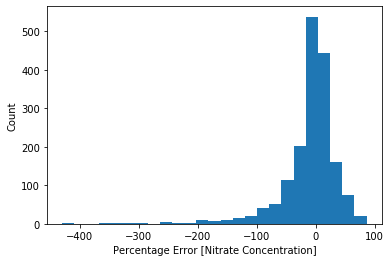

In [87]:
error = (test_labels - test_predictions)/test_labels*100
plt.hist(error, bins = 25)
plt.xlabel("Percentage Error [Nitrate Concentration]")
_ = plt.ylabel("Count")

(array([  1.,   0.,   0.,   1.,   1.,   3.,   1.,   0.,   4.,   3.,   3.,
         10.,   7.,  11.,  15.,  21.,  40.,  52., 114., 201., 538., 444.,
        161.,  76.,  20.]),
 array([-429.60404983, -408.96892749, -388.33380514, -367.6986828 ,
        -347.06356046, -326.42843811, -305.79331577, -285.15819343,
        -264.52307108, -243.88794874, -223.2528264 , -202.61770405,
        -181.98258171, -161.34745937, -140.71233702, -120.07721468,
         -99.44209234,  -78.80696999,  -58.17184765,  -37.53672531,
         -16.90160297,    3.73351938,   24.36864172,   45.00376406,
          65.63888641,   86.27400875]),
 <a list of 25 Patch objects>)

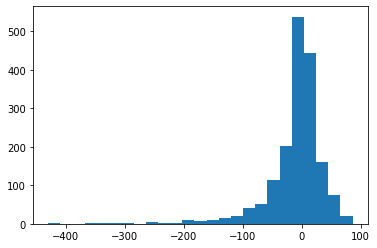

In [88]:
plt.hist(error, bins=25)

In [89]:
len(error)

1727

In [90]:
idx_large_error = np.where(np.abs(error) > 100)

In [91]:
large_error_test_dataset = test_dataset.iloc[idx_large_error]
large_error_test_dataset

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
111,-1.790849,0.754727,-0.289688,1.538778,-1.524726,-0.554469
141,-1.790849,1.140974,-0.289688,-0.221392,-0.073668,-1.806710
269,-1.700694,-0.869491,-0.289688,-0.221392,2.073898,-1.493650
395,-1.700694,0.596267,-0.289688,-0.573426,-0.073668,-0.232713
747,-1.610539,0.487325,-0.289688,-0.221392,-0.538006,-0.232713
...,...,...,...,...,...,...
15025,2.536588,1.319242,3.494570,-1.101477,1.716938,1.245627
15154,2.716897,1.091455,3.150546,0.869914,-1.507313,-0.884922
15208,2.807052,1.269723,3.322558,-1.981563,1.449943,0.176004
15350,3.077517,0.279346,-0.117676,-1.629528,0.204935,0.906478


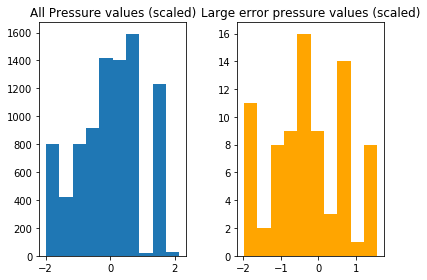

In [110]:
plt.subplot(1,2,1)
plt.hist(nitrate.PRESSURE)
plt.title("All Pressure values (scaled)")
plt.subplot(1,2,2)
plt.hist(large_error_test_dataset.PRESSURE, color="orange")
plt.title("Large error pressure values (scaled)")
plt.tight_layout()
# plt.ylim([0,200])
# plt.legend()

Text(0.5, 1.0, 'Large error temperature values (scaled)')

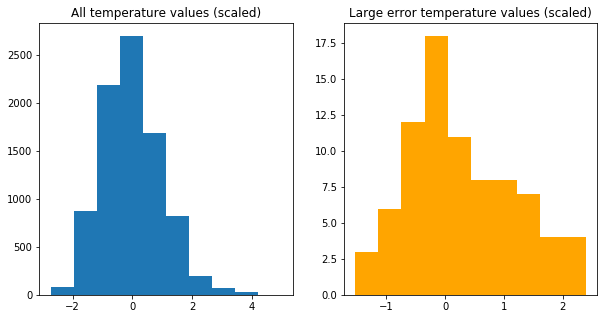

In [120]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(nitrate.TEMPERATURE_VALUE)
axes[0].set_title("All temperature values (scaled)")
# plt.subplot(1,2,2)
axes[1].hist(large_error_test_dataset.TEMPERATURE_VALUE, color = "orange")
axes[1].set_title("Large error temperature values (scaled)")

Text(0.5, 1.0, 'Large error hour values (scaled)')

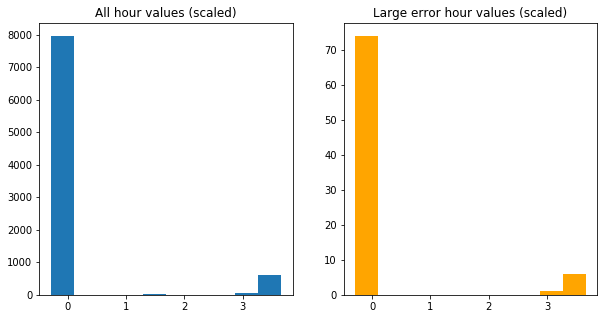

In [121]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].hist(nitrate.Hour)
axes[0].set_title("All hour values (scaled)")
# plt.subplot(1,2,2)
axes[1].hist(large_error_test_dataset.Hour, color = "orange")
axes[1].set_title("Large error hour values (scaled)")

(array([2990., 1427., 1188., 1276.,  993.,  534.,  183.,   31.,    8.,
           3.]),
 array([ 1.01 ,  2.909,  4.808,  6.707,  8.606, 10.505, 12.404, 14.303,
        16.202, 18.101, 20.   ]),
 <a list of 10 Patch objects>)

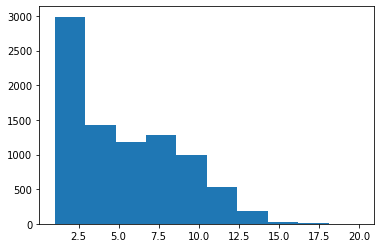

In [169]:
plt.hist(nitrate.NITRATE_VALUE)

(array([31., 20.,  8.,  2.,  9.,  5.,  1.,  1.,  2.,  2.]),
 array([1.04 , 1.346, 1.652, 1.958, 2.264, 2.57 , 2.876, 3.182, 3.488,
        3.794, 4.1  ]),
 <a list of 10 Patch objects>)

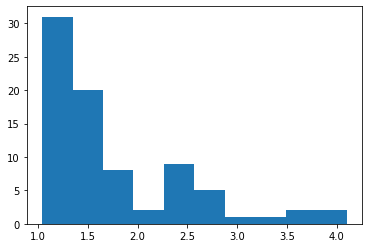

In [171]:
plt.hist(test_labels.iloc[idx_large_error])

(array([20., 23.,  7., 13.,  9.,  3.,  3.,  0.,  1.,  2.]),
 array([ 2.2800972,  3.1649504,  4.0498033,  4.9346566,  5.8195095,
         6.7043624,  7.5892158,  8.474069 ,  9.358922 , 10.243774 ,
        11.128628 ], dtype=float32),
 <a list of 10 Patch objects>)

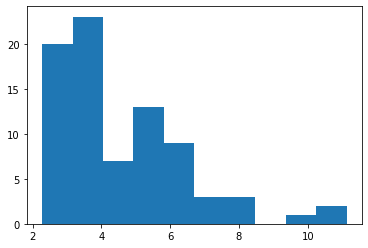

In [173]:
plt.hist(test_predictions[idx_large_error])

In [122]:
import pickle

In [123]:
pickle_in = open("../data/standardisation_nitrate.pickle", "rb")
nitrate_stats = pickle.load(pickle_in)
nitrate_stats.drop(['TEMPERATURE_QC_FLAG','SALINITY_QC_FLAG','NITRATE_QC_FLAG','NITRATE_VALUE'], inplace=True)
nitrate_stats

,count,mean,std,min,25%,50%,75%,max
Year,8633.0,1973.864126,11.092018,1953.000,1967.000,1973.000,1979.000,2010.000
Yday,8633.0,189.793930,100.971686,1.000,103.000,201.000,271.000,365.000
Hour,8633.0,1.684119,5.813557,0.000,0.000,0.000,0.000,23.000
PRESSURE,8633.0,56.288938,28.406338,0.000,40.000,53.000,75.000,117.000
TEMPERATURE_VALUE,8633.0,16.426921,1.722881,11.740,15.233,16.300,17.500,25.010
SALINITY_VALUE,8633.0,35.452761,0.114994,35.009,35.375,35.455,35.535,35.787


In [124]:
large_error_test_dataset = large_error_test_dataset * nitrate_stats['std'] + nitrate_stats['mean']

In [128]:
nitrate_descaled = nitrate * nitrate_stats['std'] + nitrate_stats['mean']

In [125]:
large_error_test_dataset.describe() - nitrate_stats.transpose()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
count,-8552.000000,-8552.000000,-8.552000e+03,-8552.000000,-8552.000000,-8552.000000
mean,-0.567830,20.860391,1.924241e-01,-5.016098,0.471783,0.027918
std,1.995614,-16.003433,2.884560e-01,-0.513243,-0.143024,-0.024372
min,1.000000,6.000000,2.220446e-16,0.000000,2.060000,0.222000
25%,-3.000000,41.000000,2.220446e-16,-10.000000,0.567000,0.059000
50%,-1.000000,20.000000,2.220446e-16,-3.000000,0.323000,0.034000
75%,1.000000,5.000000,2.220446e-16,0.000000,0.500000,0.003000
max,-1.000000,-8.000000,0.000000e+00,-15.900000,-4.460000,-0.084000


In [126]:
large_error_test_dataset.describe()

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
count,81.000000,81.000000,8.100000e+01,81.000000,81.000000,81.000000
mean,1973.296296,210.654321,1.876543e+00,51.272840,16.898704,35.480679
std,13.087632,84.968253,6.102013e+00,27.893095,1.579856,0.090621
min,1954.000000,7.000000,2.220446e-16,0.000000,13.800000,35.231000
25%,1964.000000,144.000000,2.220446e-16,30.000000,15.800000,35.434000
50%,1972.000000,221.000000,2.220446e-16,50.000000,16.623000,35.489000
75%,1980.000000,276.000000,2.220446e-16,75.000000,18.000000,35.538000
max,2009.000000,357.000000,2.300000e+01,101.100000,20.550000,35.703000


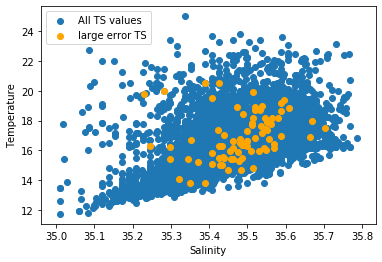

In [131]:
plt.scatter(nitrate_descaled.SALINITY_VALUE, nitrate_descaled.TEMPERATURE_VALUE, label="All TS values")
plt.scatter(large_error_test_dataset.SALINITY_VALUE, large_error_test_dataset.TEMPERATURE_VALUE, c="orange", label="large error TS")
plt.xlabel("Salinity")
plt.ylabel("Temperature")
plt.legend()

In [133]:
import datetime 

In [168]:
nitrate_descaled = nitrate_descaled.assign(dtime_str = lambda x: x.Year.astype(int).astype(str)+" "+x.Yday.astype(int).astype(str)+" "+x.Hour.astype(int).astype(str))
nitrate_descaled["datetime"] = [datetime.datetime.strptime(y, "%Y %j %H") for y in nitrate_descaled.dtime_str]
# type(nitrate_descaled)
# [ datetime.datetime.strptime("%s %s %s" % (y, d, h), "%Y %j %H") 
#  for y,d in zip(nitrate_descaled.Year.astype(int), nitrate_descaled.Yday.astype(int), nitrate_descaled.Hour.astype(int))]
# datetime.datetime.strptime("%s %s" % (nitrate_descaled.Year.astype(int),  nitrate_descaled.Yday.astype(int)), "%Y %j")

In [166]:
nitrate_descaled

,Hour,NITRATE_VALUE,PRESSURE,SALINITY_VALUE,TEMPERATURE_VALUE,Yday,Year,dtime,datetime
3,2.220446e-16,NaN,30.0,35.462,18.800,151.0,1953.0,1953 151 0,1953-05-31 00:00:00
6,2.220446e-16,NaN,75.0,35.480,17.100,151.0,1953.0,1953 151 0,1953-05-31 00:00:00
7,2.220446e-16,NaN,100.0,35.570,16.200,151.0,1953.0,1953 151 0,1953-05-31 00:00:00
12,2.220446e-16,NaN,40.0,35.462,18.000,160.0,1953.0,1953 160 0,1953-06-09 00:00:00
14,2.220446e-16,NaN,75.0,35.444,17.900,160.0,1953.0,1953 160 0,1953-06-09 00:00:00
...,...,...,...,...,...,...,...,...,...
15532,2.300000e+01,NaN,75.0,35.395,15.760,49.0,2010.0,2010 49 23,2010-02-18 23:00:00
15533,2.300000e+01,NaN,100.0,35.306,14.170,49.0,2010.0,2010 49 23,2010-02-18 23:00:00
15540,2.200000e+01,NaN,50.0,35.428,16.060,76.0,2010.0,2010 76 22,2010-03-17 22:00:00
15542,2.200000e+01,NaN,75.0,35.321,14.716,76.0,2010.0,2010 76 22,2010-03-17 22:00:00


In [94]:
nitrate_stats

,count,mean,std,min,25%,50%,75%,max
Year,13193.0,1973.573259,10.881569,1953.000,1966.000,1973.000,1979.000,2010.000
Yday,13193.0,185.897294,103.373658,1.000,97.000,191.000,273.000,365.000
Hour,13193.0,1.569923,5.623926,0.000,0.000,0.000,0.000,23.000
PRESSURE,13193.0,49.625294,40.673437,0.000,20.000,50.000,75.000,300.000
TEMPERATURE_VALUE,13193.0,17.268298,2.314093,10.110,15.600,16.988,18.690,25.230
SALINITY_VALUE,13193.0,35.458125,0.159694,31.924,35.384,35.472,35.552,35.967


In [68]:
nitrate_descaled = nitrate * nitrate_stats['std'] + nitrate_stats['mean']

In [69]:
len(np.where((nitrate_descaled.PRESSURE > 85) & (nitrate_descaled.PRESSURE < 115))[0])

1271

In [70]:
test_dataset

,Year,Yday,Hour,PRESSURE,TEMPERATURE_VALUE,SALINITY_VALUE
3,-1.881004,-0.384206,-0.289688,-0.925460,1.377390,0.080347
24,-1.881004,-0.096997,-0.289688,-1.981563,0.622840,0.393407
42,-1.881004,0.051560,-0.289688,-1.277494,0.332628,0.862998
45,-1.881004,0.051560,-0.289688,-0.221392,0.332628,-0.076183
46,-1.881004,0.051560,-0.289688,0.658693,0.216544,0.080347
...,...,...,...,...,...,...
15458,3.167672,0.725016,3.494570,-1.101477,-0.950107,-0.815353
15494,3.167672,1.002321,3.666581,1.538778,-0.613462,-0.537077
15513,3.167672,1.487606,3.494570,0.658693,-0.275655,0.019474
15533,3.257827,-1.394390,3.666581,1.538778,-1.309969,-1.276247


In [71]:
large_error_comp = pd.DataFrame({'test_labels': test_labels.iloc[idx_large_error], 
                                 'test_predictions': test_predictions[idx_large_error]})
large_error_comp

,test_labels,test_predictions
111,1.40,3.544721
141,2.50,6.551746
269,1.20,4.042725
395,1.30,2.877624
687,1.40,2.951205
...,...,...
15025,1.20,3.669844
15154,4.10,11.023280
15208,1.18,4.695668
15350,1.55,3.224678


In [72]:
large_error_comp.describe()

,test_labels,test_predictions
count,61.000000,61.000000
mean,1.799672,4.906625
std,0.722182,1.924031
min,1.040000,2.260412
25%,1.210000,3.257059
50%,1.500000,4.387197
75%,2.300000,6.107732
max,4.100000,11.023280


Text(0, 0.5, 'Count')

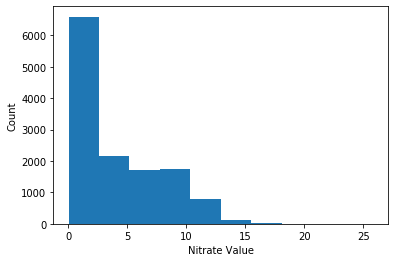

In [59]:
plt.hist(nitrate.NITRATE_VALUE)
plt.xlabel('Nitrate Value')
plt.ylabel('Count')

In [60]:
len(np.where(test_predictions < 0))

1

In [ ]:
large_error_df = pd.concat()

## Regularization

In [10]:
from tensorflow.keras import regularizers

In [11]:
def build_model():
    model = keras.Sequential([
      layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())], kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 168,849
Trainable params: 168,849
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.01530169],
       [-0.05037046],
       [-0.02797367],
       [-0.01440519],
       [-0.01344237],
       [ 0.02157168],
       [ 0.03819755],
       [-0.03085784],
       [-0.02664502],
       [-0.05601852]], dtype=float32)

In [15]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [16]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.709616,1.142908,2.547100,31.481304,3.121700,1.232243,2.960940,36.276771
std,0.450483,0.095182,0.415145,2.334379,0.288391,0.069236,0.262804,3.398964
min,2.279152,1.029336,2.109410,28.548147,2.767420,1.136774,2.605164,31.764135
25%,2.413615,1.070300,2.259349,29.642431,2.938405,1.185307,2.793077,33.807197
50%,2.588010,1.115971,2.446923,30.867754,3.015689,1.211409,2.877081,35.680052
75%,2.881899,1.196819,2.742590,32.837027,3.239759,1.272253,3.090671,37.399750
max,5.703371,1.643589,5.256795,42.490841,4.347743,1.496723,3.965343,48.622017


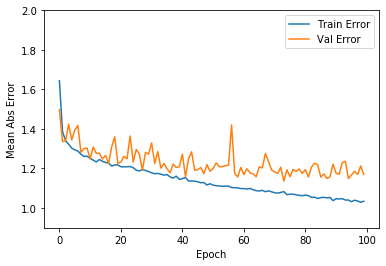

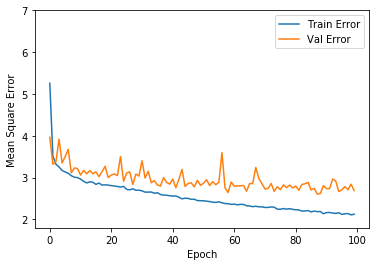

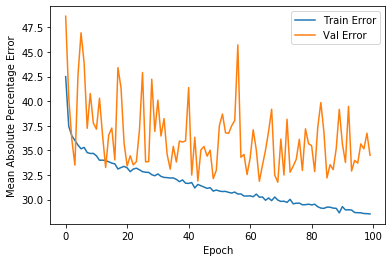

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [26]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(512, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [27]:
model = build_model()

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 512)               3584      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                

In [29]:
# Try out model with example batch
example_batch = train_dataset[:10]
example_result = model.predict(example_batch)
example_result

array([[0.02398698],
       [0.12459408],
       [0.08351785],
       [0.01977466],
       [0.08826135],
       [0.13829444],
       [0.06811555],
       [0.05041648],
       [0.01989299],
       [0.10928319]], dtype=float32)

In [30]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [31]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.650891,1.394736,3.650891,36.260292,3.053179,1.273415,3.053179,37.462547
std,0.896836,0.148726,0.896836,1.799628,0.383850,0.082761,0.383850,2.072297
min,2.811973,1.240813,2.811973,34.832699,2.710922,1.184993,2.710922,32.957153
25%,3.001090,1.289539,3.001089,35.456997,2.840459,1.223434,2.840458,36.470401
50%,3.297271,1.340985,3.297271,35.769667,2.938647,1.248815,2.938647,37.356159
75%,3.974422,1.447635,3.974420,36.168791,3.120779,1.298161,3.120779,38.259933
max,7.826931,2.054883,7.826931,47.549355,5.385348,1.730634,5.385348,51.193836


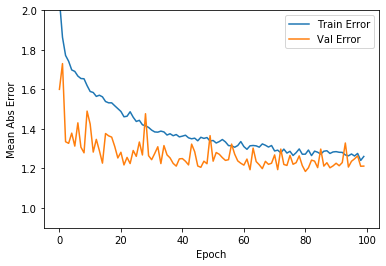

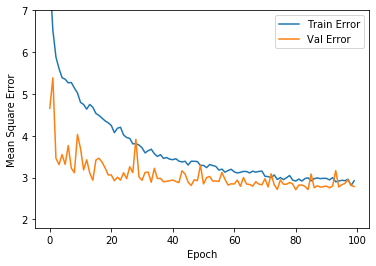

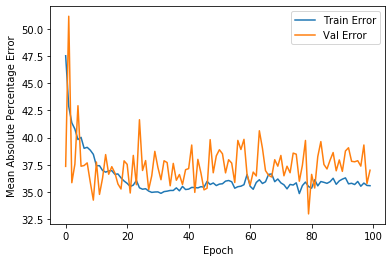

In [32]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [33]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [34]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.738169,1.226902,2.738169,35.224984,2.780224,1.215663,2.780224,37.519966
std,0.078373,0.019144,0.078373,0.463564,0.070153,0.028984,0.070153,1.570316
min,2.550224,1.177760,2.550224,33.880344,2.636920,1.160009,2.636919,33.340538
25%,2.674044,1.211081,2.674044,34.880694,2.728418,1.195471,2.728417,36.402322
50%,2.728486,1.224548,2.728486,35.166218,2.770704,1.211758,2.770704,37.792889
75%,2.798887,1.244116,2.798887,35.545717,2.824836,1.235306,2.824836,38.431901
max,2.904076,1.264598,2.904076,36.314838,3.043350,1.313808,3.043350,41.528221


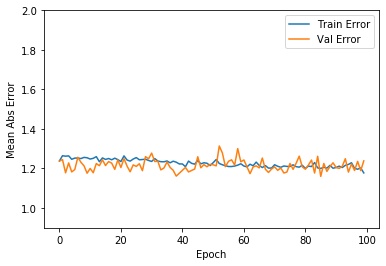

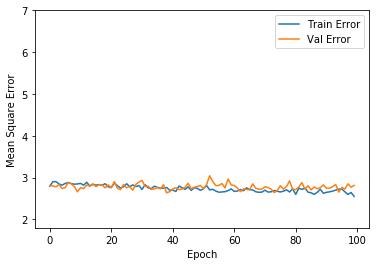

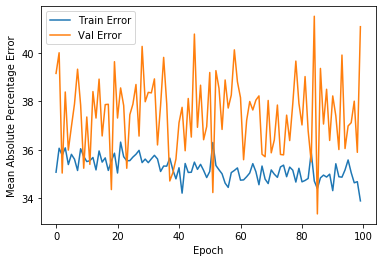

In [35]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

*Increase complexity!*

In [36]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(1024, activation='relu', input_shape=[len(train_dataset.keys())]),
      layers.Dropout(0.2),
      layers.Dense(512, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [37]:
model = build_model()

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              7168      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [40]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [41]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3.835541,1.424662,3.835541,37.074840,3.132424,1.291980,3.132424,38.131111
std,1.140432,0.179721,1.140432,1.941445,0.551366,0.110763,0.551366,2.400903
min,2.844842,1.251212,2.844841,35.248749,2.686502,1.190274,2.686502,33.311462
25%,3.061863,1.302143,3.061863,36.278522,2.874549,1.231322,2.874549,36.305218
50%,3.383219,1.361867,3.383219,36.553907,2.971993,1.269732,2.971993,37.885082
75%,4.106801,1.467329,4.106802,36.984717,3.192732,1.309891,3.192732,39.677682
max,8.942276,2.199609,8.942280,49.528214,7.030513,2.014315,7.030513,45.471191


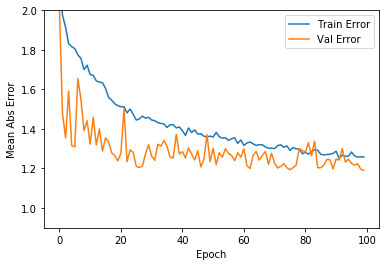

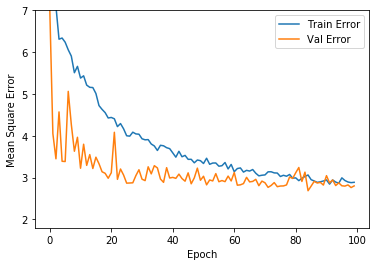

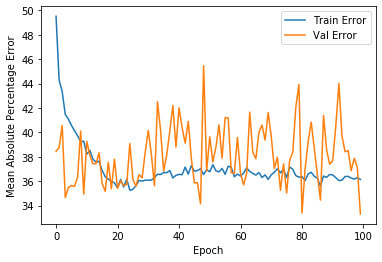

In [42]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

In [43]:
## Train the model for another 100 epochs
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [44]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.645430,1.202496,2.645430,35.014897,2.861304,1.227619,2.861304,38.010918
std,0.106750,0.026347,0.106750,0.604906,0.075528,0.029304,0.075528,2.284333
min,2.424249,1.151703,2.424249,33.485352,2.682542,1.175827,2.682541,33.304104
25%,2.566409,1.183567,2.566409,34.589264,2.808233,1.205065,2.808232,36.362545
50%,2.640727,1.200268,2.640729,35.035883,2.845078,1.223127,2.845077,37.973866
75%,2.720790,1.222807,2.720790,35.398572,2.902937,1.251714,2.902938,39.496066
max,2.885484,1.255691,2.885484,36.422970,3.099908,1.307348,3.099908,43.054363


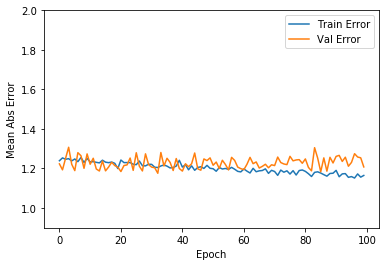

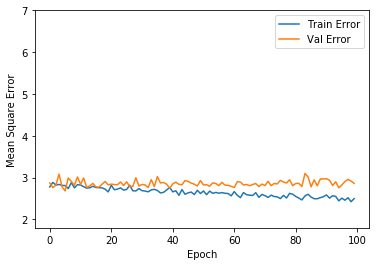

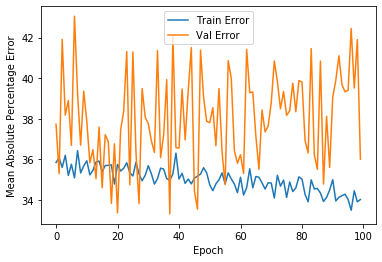

In [45]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)

*Combined regularization with high complexity*

In [46]:
# Dropout

def build_model():
    model = keras.Sequential([
      layers.Dense(1024, activation='relu', input_shape=[len(train_dataset.keys())],kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
      layers.Dropout(0.2),
      layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop()
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse', tf.keras.metrics.MeanAbsolutePercentageError()])
    
    return model

In [47]:
model = build_model()

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1024)              7168      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)              

In [49]:
## Train the model
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 200

history = model.fit(
  train_dataset, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................

In [50]:
pd.DataFrame(history.history).describe()

,loss,mae,mse,mean_absolute_percentage_error,val_loss,val_mae,val_mse,val_mean_absolute_percentage_error
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,4.303126,1.537729,4.158177,42.629490,3.384975,1.368197,3.242579,43.379954
std,0.694057,0.082863,0.636889,1.592508,0.465224,0.080479,0.427361,2.481539
min,3.918306,1.481924,3.764416,37.154495,3.079515,1.250811,2.932963,34.264015
25%,4.038216,1.504131,3.896637,42.762173,3.207587,1.325792,3.076847,43.416080
50%,4.098811,1.515246,3.960970,43.051176,3.285138,1.354787,3.164510,44.075985
75%,4.219753,1.537251,4.098921,43.368457,3.408278,1.388572,3.282596,44.760581
max,9.814636,2.191384,8.861682,49.056442,7.225908,1.973549,6.930098,46.945122


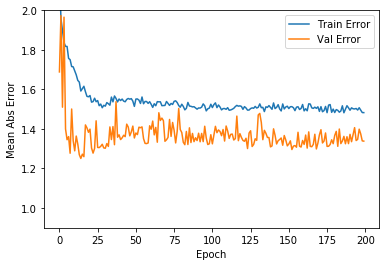

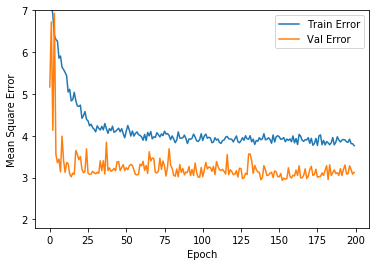

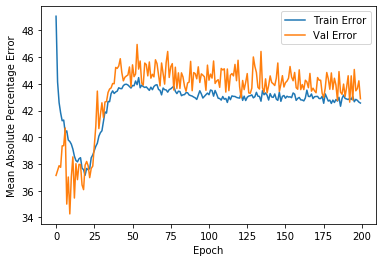

In [51]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.9,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([1.8,7])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
  #plt.ylim([80,160])
  plt.legend()
  plt.show()


plot_history(history)